## Heat-Treatment Progression Degree (HTPD)
- スペクトルの生成
- HTPDによる順位付けと解釈

In [1]:
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")

from pathlib import Path
from dataclasses import asdict
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from chemomae.models import ChemoMAE

from src.core import load_config, RUNS_DIR, DATA_DIR, IMAGES_DIR
from src.viz import get_glasbey_with_white
from src.htpd import (
    SphericalPGA1D,
    generate_reflectance_snv_from_htpd_grid,
    plot_generated_reflectance_snv_gradient,
    make_generated_reflectance_snv_gif,
    ) 

WEIGHTS_PATH = RUNS_DIR / "best_model.pt"
PGA_PATH: Path = RUNS_DIR / "pga.pt"

In [2]:
model = ChemoMAE(**asdict(load_config().model))
state = torch.load(WEIGHTS_PATH, map_location="cpu")
model.load_state_dict(state, strict=True)
model.to("cuda")
print(model)

ChemoMAE(
  (encoder): ChemoEncoder(
    (patch_proj): Linear(in_features=7, out_features=256, bias=False)
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (to_latent): Linear(in_features=256, out_features=8, bias=True)
  )
  (decoder): ChemoDecoder(
    (net): Linear(in_features=8, out_features=210, bias

c:\Users\PC_User\anaconda3\envs\torch_env\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [3]:
pga = SphericalPGA1D.load(PGA_PATH)

print("=== Key PGA attributes ===")
keys = [
    "is_fitted_",
    "explained_var_ratio_",
    "mu_",
    "v_mean_",
    "p_",
    "t_min_",
    "t_max_",
    "t_lo_",
    "t_hi_"
]

for k in keys:
    if not hasattr(pga, k):
        print(f"{k}: <not found>")
        continue

    v = getattr(pga, k)

    if isinstance(v, torch.Tensor):
        print(f"{k}: Tensor shape={tuple(v.shape)}, device={v.device}, dtype={v.dtype}")
    elif isinstance(v, np.ndarray):
        print(f"{k}: ndarray shape={v.shape}, dtype={v.dtype}")
    else:
        # bool / float / int / etc.
        print(f"{k}: {v} (type={type(v).__name__})")

=== Key PGA attributes ===
is_fitted_: True (type=bool)
explained_var_ratio_: 0.7397393711347344 (type=float)
mu_: Tensor shape=(8,), device=cpu, dtype=torch.float32
v_mean_: Tensor shape=(8,), device=cpu, dtype=torch.float32
p_: Tensor shape=(8,), device=cpu, dtype=torch.float32
t_min_: -0.5888810753822327 (type=float)
t_max_: 1.3470258712768555 (type=float)
t_lo_: -0.41341081261634827 (type=float)
t_hi_: 0.9839195013046265 (type=float)


- PGA1次元で全分散の約 74 % を説明
- 劣化進行がほぼ 1 次元多様体に乗っている
- PGA1D = 劣化軸、という仮定は妥当
- -> HTPD を単一スカラーで定義してよい根拠

### HTPD スコアからスペクトルを生成

In [4]:
wave_nm = np.load(DATA_DIR / "spectra/wavenumber.npy")
wave_cm = 1e7 / wave_nm

htpd_grid = np.linspace(0.0, 1.0, 100)

x_gen_snv = generate_reflectance_snv_from_htpd_grid(
    model=model,
    pga=pga,
    htpd_grid=htpd_grid,
    device="cuda",
)

plot_generated_reflectance_snv_gradient(
    wave_cm=wave_cm,
    x_gen_snv=x_gen_snv,
    htpd_grid=htpd_grid,
    save_path=IMAGES_DIR / "spectra" / "gen_ref_snv_gradient.png",
    figsize=(12, 5),
    ylims=(-3, 3),
)

make_generated_reflectance_snv_gif(
    wave_cm=wave_cm,
    x_gen_snv=x_gen_snv,
    htpd_grid=htpd_grid,
    save_path=IMAGES_DIR / "spectra" / "gen_ref_snv_progress.gif",
    figsize=(12, 5),
    fps=20,
    ylims=(-3, 3),
)

WindowsPath('D:/UnsupervisedSegmentation_NIR-HSI/HeatTreatedWoodSeg_NIR-HSI/images/spectra/gen_ref_snv_progress.gif')

| PNG | GIF |
|----|----|
| <img src="images/spectra/gen_ref_snv_gradient.png" width=600> | <img src="images/spectra/gen_ref_snv_progress.gif" width=600> |

In [5]:
spactra_path = DATA_DIR / "spectra" / "class_avgs.npz"
data = np.load(spactra_path)
for k in data.files:
    arr = data[k]
    print(f"{k}: shape={arr.shape}, dtype={arr.dtype}")


wavenumber_cm: shape=(210,), dtype=float64
uniq: shape=(9,), dtype=int64
ref: shape=(9, 210), dtype=float32
snv: shape=(9, 210), dtype=float32
absorb: shape=(9, 210), dtype=float32
absorb_snv: shape=(9, 210), dtype=float32


In [6]:
# クラス平均スペクトル（SNV後）と対応するクラス名を取得
ref_snv = data["snv"]        # shape: (n_classes, n_wavelengths)
classes = data["uniq"]       # shape: (n_classes,)

ref_snv_tensor = torch.from_numpy(ref_snv.astype(np.float32)).to("cuda")

# Encoder による潜在表現の抽出
z = model.encoder(
    ref_snv_tensor,
    torch.ones(ref_snv.shape[0], 210, dtype=torch.bool, device="cuda")  # 全波長可視
)

# 潜在表現 z を PGA により 1 次元の劣化指標（HTPD）へ写像
# normalize=True により、球面上の測地距離に基づく座標を使用
htpd = pga.transform(z, normalize=True)

htpd_np = htpd.detach().cpu().numpy().reshape(-1)

# HTPD が大きい順（＝劣化進行度が高い順）にソートしたインデックス
order = np.argsort(-htpd_np)

# クラス名をキーとして、HTPD に基づく順位とスカラー値を記録した辞書を作成
# rank は 1 始まり（1 が最も劣化が進行しているクラス）
rank_dict = {
    classes[idx]: {
        "rank": rank + 1,
        "htpd": float(htpd_np[idx]),
    }
    for rank, idx in enumerate(order)
}

print(rank_dict)

{np.int64(6): {'rank': 1, 'htpd': 0.9892255663871765}, np.int64(4): {'rank': 2, 'htpd': 0.7521637082099915}, np.int64(1): {'rank': 3, 'htpd': 0.6158652901649475}, np.int64(3): {'rank': 4, 'htpd': 0.419752836227417}, np.int64(8): {'rank': 5, 'htpd': 0.4018562436103821}, np.int64(0): {'rank': 6, 'htpd': 0.2419911026954651}, np.int64(2): {'rank': 7, 'htpd': 0.2378494143486023}, np.int64(7): {'rank': 8, 'htpd': 0.09009543806314468}, np.int64(5): {'rank': 9, 'htpd': 0.06144549697637558}}


### HTPD に基づくクラス順位一覧

HTPD（Heat-Treatment Progression Degree）は、
ChemoMAE により得られた潜在表現を **PGA によって 1 次元へ射影**した劣化進行指標である。
値が大きいほど、劣化が進行していると解釈する。

#### 補足・解釈メモ

* **Rank = 1** が最も HTPD が高く、
  **Rank が大きいほど劣化が小さいクラス**
* HTPD は **連続量**であり、クラスタリング結果を **擬似的な劣化軸（ordinal scale）** として並べ替える目的で使用
* Class ID は `data["uniq"]` に対応（整数ラベル）

---

### 二次微分スペクトルの並び替え

In [7]:
spectra_2nd_deriv = DATA_DIR / "spectra" / "class_avg_absorbance_sg_deriv.npz"
data = np.load(spectra_2nd_deriv)
for k in data.files:
    arr = data[k]
    print(f"{k}: shape={arr.shape}, dtype={arr.dtype}")

wavenumber_cm: shape=(210,), dtype=float64
uniq: shape=(9,), dtype=int64
absorb_sg_deriv: shape=(9, 210), dtype=float32
deriv_order: shape=(), dtype=int64
window_length: shape=(), dtype=int64
polyorder: shape=(), dtype=int64
delta: shape=(), dtype=float64


In [8]:
# 可視化用：HTPD 昇順（健全 → 劣化）
order_vis = order[::-1]

spec_2nd = data["absorb_sg_deriv"] 
spec_2nd_sorted = spec_2nd[order_vis]
htpd_sorted = htpd_np[order_vis]
classes_sorted = classes[order_vis]

row_labels = [
    f"{cls} (HTPD={htpd:.2g})"
    for cls, htpd in zip(classes_sorted, htpd_sorted)
]

In [9]:
def plot_stacked_spectra(
    wavenumber_cm: np.ndarray,
    spectra: np.ndarray,   # (K, L) 上→下 = 健全→劣化
    classes_sorted: np.ndarray,    # (K,)
    htpd_sorted: np.ndarray,       # (K,)
    figure_size=(15, 10),
    offset: float | None = None,
):
    """
    HTPD 昇順でスペクトルを縦に並べて描画する。
    """
    wn = np.asarray(wavenumber_cm, float)
    Z = np.asarray(spectra, float)
    classes_sorted = np.asarray(classes_sorted)
    htpd_sorted = np.asarray(htpd_sorted)

    K, L = Z.shape

    # --- オフセット自動決定（見やすさ優先）
    if offset is None:
        s = np.nanpercentile(np.abs(Z), 95)
        offset = 2.5 * s

    # --- Glasbey（class ID に対応させる）
    cmap = get_glasbey_with_white(int(classes_sorted.max()) + 1)

    fig, ax = plt.subplots(1, 1, figsize=figure_size)

    for i in range(K):
        # 上が健全、下が劣化になるように描画位置を反転
        y0 = (K - 1 - i) * offset
        y = Z[i] + y0

        cls = int(classes_sorted[i])
        color = cmap.colors[cls + 1]  # +1 は white 分

        ax.plot(
            wn,
            y,
            lw=1.2,
            color=color,
        )

        # 各クラスのゼロライン（比較用）
        ax.axhline(y0, color="k", lw=0.4, alpha=0.35)

    # --- y 軸ラベル（中央）
    ax.set_yticks([(K - 1 - i) * offset for i in range(K)])
    ax.set_yticklabels(
        [f"class{c} (HTPD={h:.3g})" for c, h in zip(classes_sorted, htpd_sorted)]
    )
    ax.tick_params(axis="y", length=0)

    # --- x 軸レイアウト（既存関数と統一）
    ax.set_xlim(10000, 4500)
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.set_xlabel("Wavenumber (cm$^{-1}$)")
    ax.set_ylabel("Absorbance 2nd derive (SG)")

    ax.grid(True, which="both")
    ax.grid(True, which="minor", linestyle=":", lw=0.5)

    plt.tight_layout()
    return fig, ax

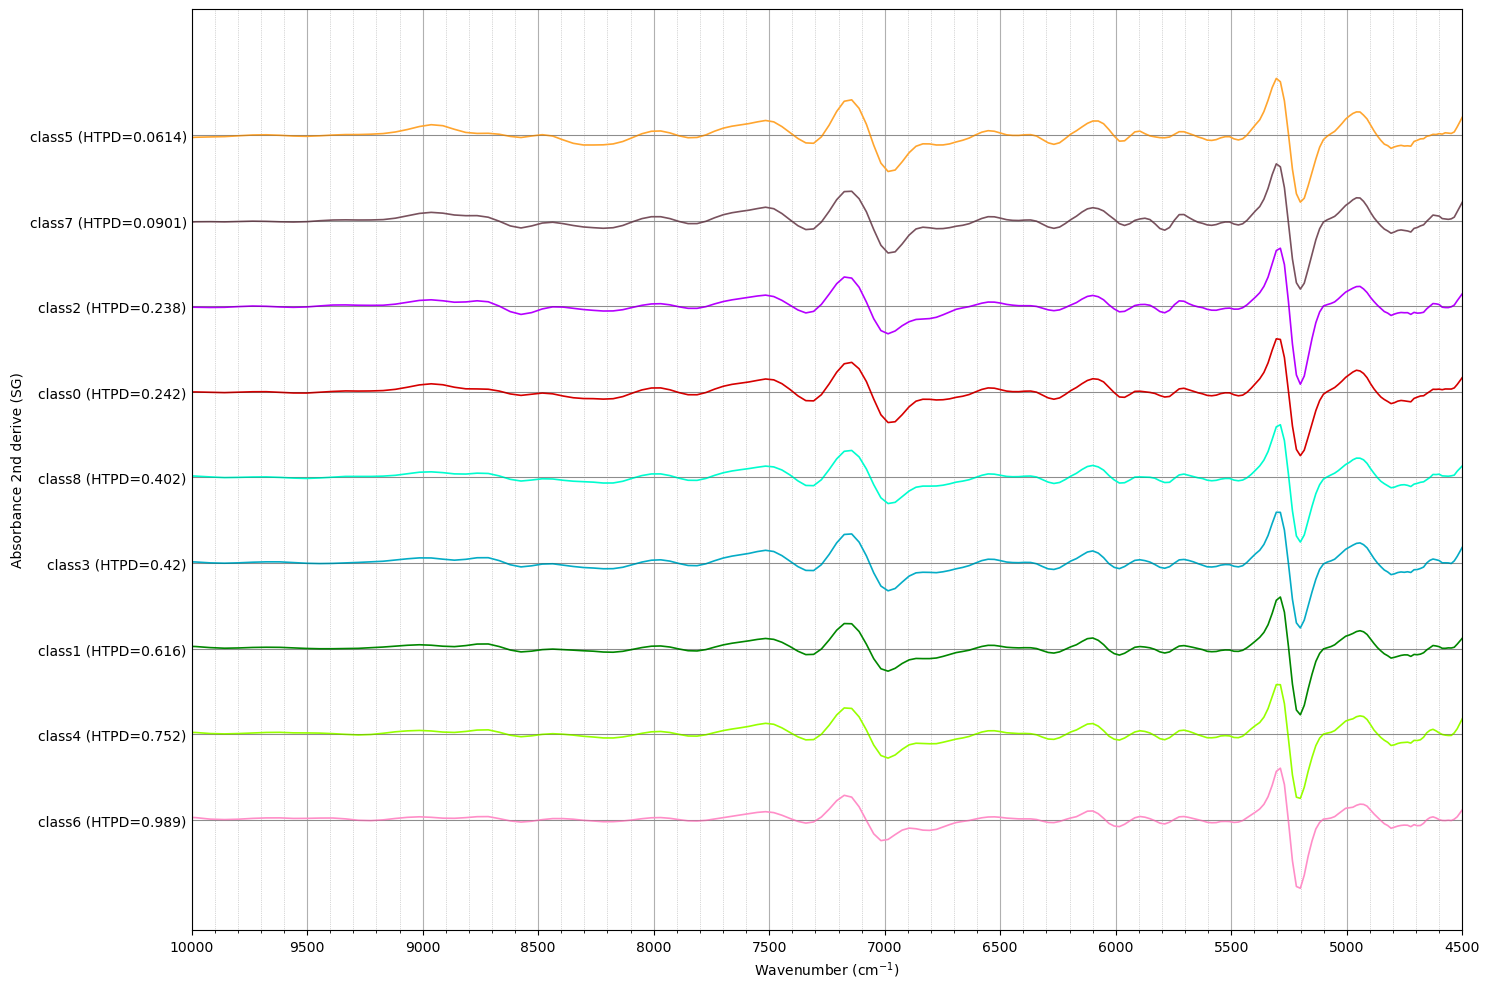

In [10]:
plot_stacked_spectra(wave_cm, spec_2nd_sorted, classes_sorted, htpd_sorted)
plt.savefig(IMAGES_DIR/"spectra"/"cluster_spectra_2nd_derive_sorted.png");